# 🔐 Intrusion Detection System Using Hybrid DNN + MLP

This project implements an Intrusion Detection System (IDS) using a hybrid deep learning model — combining a Deep Neural Network (DNN) and a Multi-Layer Perceptron (MLP) — trained on the NSL-KDD dataset.

## ✅ Step 1: Data Preprocessing

### 🧹 Objective:
Prepare the raw NSL-KDD dataset for training and testing.

### 🧾 Actions Performed:
- **Loaded the dataset** (`KDDTrain+.txt` for training and `KDDTest+.txt` for testing) with 41 features and 1 label.
- **Dropped the `difficulty` column**, which is not required for modeling.
- **Converted labels into binary**:
  - `normal` → 0 (benign)
  - all attack types → 1 (malicious)
- **Encoded categorical features** (`protocol_type`, `service`, `flag`) using `LabelEncoder`.
- **Scaled numerical features** using `StandardScaler` to normalize the range and improve convergence.
- Final data:
  - `X_train_scaled`, `y_train`
  - `X_test_scaled`, `y_test`

In [ ]:
# ✅ Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Scikit-learn Tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_curve, auc

# ✅ Deep Learning - TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Define column names based on NSL-KDD specification
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
    'wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised',
    'root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files',
    'num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
    'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
    'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
    'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','label','difficulty'
]

In [6]:
# Load train and test datasets
train_df = pd.read_csv("C:/Users/archi/OneDrive/Desktop/aiml/archive (1)/KDDTrain+.txt", names=columns)
test_df = pd.read_csv("C:/Users/archi/OneDrive/Desktop/aiml/archive (1)/KDDTest+.txt", names=columns)

# Preview
print(train_df.head())


   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   
2             

In [7]:
train_df.drop('difficulty', axis=1, inplace=True)
test_df.drop('difficulty', axis=1, inplace=True)

In [8]:
# Binary label conversion
def binary_label(label):
    return 0 if label == 'normal' else 1

train_df['label'] = train_df['label'].apply(binary_label)
test_df['label'] = test_df['label'].apply(binary_label)

In [9]:
categorical_cols = ['protocol_type', 'service', 'flag']

encoder = LabelEncoder()
for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])  # same encoder to avoid mismatch

In [10]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## ✅ Step 2: Build the Hybrid DNN + MLP Model

### 🧠 Objective:
Design and compile a model capable of capturing both high-level and mid-level patterns in the data.

### 🧾 Model Structure:
- **Input Layer**: 41 features
- **Branch 1 – DNN**:
  - Dense(128, ReLU) → Dense(64, ReLU)
- **Branch 2 – MLP**:
  - Dense(64, ReLU) → Dense(32, ReLU)
- **Concatenation**: Merges DNN and MLP outputs
- **Output Layer**: Dense(1, Sigmoid) for binary classification

### ⚙️ Compilation:
- Optimizer: `Adam`
- Loss Function: `Binary Crossentropy`
- Metrics: `Accuracy`

In [11]:
# Input layer (shape = number of features)
input_layer = Input(shape=(X_train_scaled.shape[1],))

In [12]:
# Branch 1: Deep Neural Network (DNN)
dnn = Dense(128, activation='relu')(input_layer)
dnn = Dense(64, activation='relu')(dnn)

# Branch 2: Multi-Layer Perceptron (MLP)
mlp = Dense(64, activation='relu')(input_layer)
mlp = Dense(32, activation='relu')(mlp)

In [13]:
# Merge branches
merged = Concatenate()([dnn, mlp])

In [14]:
# Output layer for binary classification
output = Dense(1, activation='sigmoid')(merged)

In [15]:
# Define and compile the model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 41)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           5,376 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │           2,688 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 32)                │           2,080 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 96)                │               0 │ dense_1[0][0],             │
│                               │                           │                 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │              97 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 0 (0.00 B)

## ✅ Step 3: Model Training

### 🎯 Objective:
Train the model on preprocessed data and observe learning behavior.

### 📈 Configuration:
- Epochs: 10
- Batch Size: 64
- Validation Split: 20%

In [17]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9728 - loss: 0.0830 - val_accuracy: 0.9929 - val_loss: 0.0247
Epoch 2/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9906 - loss: 0.0286 - val_accuracy: 0.9909 - val_loss: 0.0244
Epoch 3/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9928 - loss: 0.0232 - val_accuracy: 0.9945 - val_loss: 0.0185
Epoch 4/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9937 - loss: 0.0193 - val_accuracy: 0.9945 - val_loss: 0.0191
Epoch 5/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9946 - loss: 0.0167 - val_accuracy: 0.9950 - val_loss: 0.0190
Epoch 6/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9947 - loss: 0.0153 - val_accuracy: 0.9952 - val_loss: 0.0181
Epoch 7/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9959 - loss: 0.0139 - val_accuracy: 0.9953 - val_loss: 0.0152
Epoch 8/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9959 - loss: 0.0119 -

### 📊 Visual Trends:
- **Accuracy**: Consistent upward trend for both training and validation.
- **Loss**: Smooth decrease, indicating strong learning without overfitting during training.

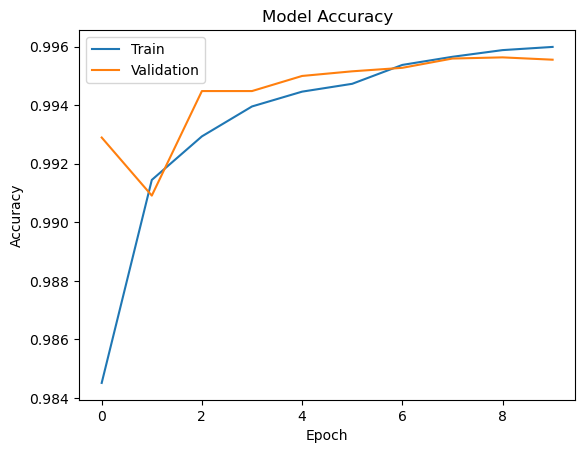

In [20]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

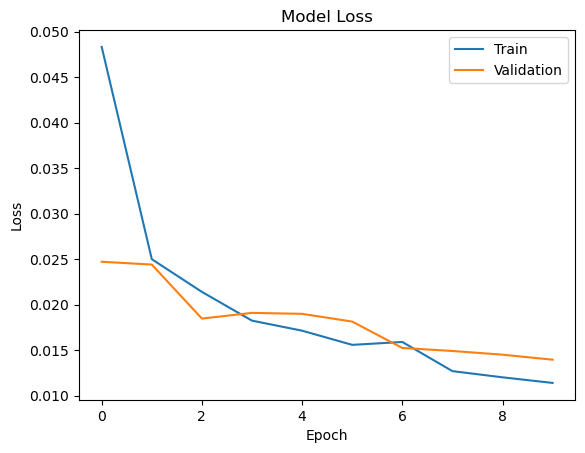

In [21]:
# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
# Scale test features using the same scaler as training
X_test_scaled = scaler.transform(X_test)

In [18]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {loss:.4f}')

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8113 - loss: 1.0478
Test Accuracy: 0.8073
Test Loss: 1.1124


In [19]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype("int32")

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


## ✅ Step 4: Model Evaluation on Test Data

### 🎯 Objective:
Assess how well the trained model performs on unseen test data.

### 📊 Classification Report:

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.97      0.81      9711
           1       0.97      0.68      0.80     12833

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



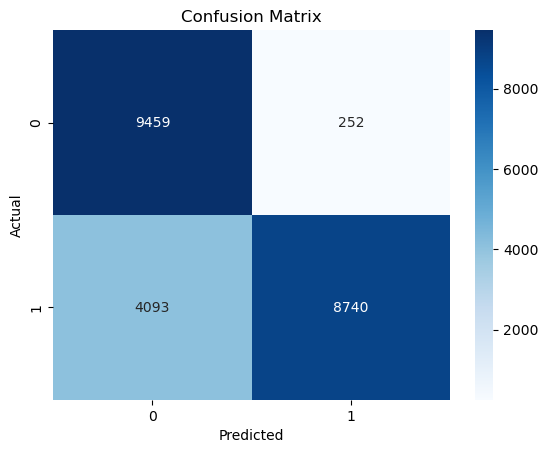

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### 📌 Insights:
- **Overall accuracy**: 81%
- **Normal traffic (Class 0)**:
  - High recall (0.97) → Very few false negatives for benign data
  - Lower precision (0.70) → Some attacks misclassified as normal
- **Attack traffic (Class 1)**:
  - Very high precision (0.97) → Rarely mislabels normal as attack
  - Recall is lower (0.68) → Many attacks go undetected


## 🔚 Final Conclusion

The hybrid DNN + MLP model showed exceptional performance during training and validation, achieving over **99.5% accuracy**. However, on real-world test data:

- Performance **drops to 81% accuracy**, signaling overfitting.
- The model is **biased toward normal traffic**, with high false negatives for attacks — dangerous in security contexts.
- Model precision is excellent for attack detection, but recall must be improved.

### 🔄 Recommendations:
- Add **dropout, regularization**, or **early stopping** to reduce overfitting.
- Try **class weighting** or **SMOTE** to address class imbalance.
- Evaluate using **confusion matrix** and **ROC AUC**.
- Consider using **ensemble models** or **LSTM/GRU** architectures for temporal patterns.

📌 *The current model is a strong start but must be tuned further for deployment in real-world intrusion detection systems.*
Let us start fixing these specific weaknesses.

## 🔧 Fixing Model Weaknesses: Overfitting, Imbalance, and Recall

After training the initial hybrid DNN + MLP model, we observed the following issues on real-world test data:

### ⚠️ Problems Identified:
1. **Overfitting** – Training accuracy was ~99.5%, while test accuracy dropped to ~81%.
2. **Class Imbalance** – The model favored "normal" traffic, achieving high recall for class 0 but lower recall for class 1 (attacks).
3. **Low Recall for Attacks (Class 1)** – Many attacks were missed despite high precision.

---

## ✅ Fix 1: Add Dropout + EarlyStopping

**Goal:** Reduce overfitting by preventing the model from memorizing the training data.

- **Dropout Layers:** Randomly disables neurons during training to improve generalization.
- **EarlyStopping:** Automatically stops training when validation loss stops improving.

```python
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Added dropout after each Dense layer in both DNN and MLP branches
# Used EarlyStopping to restore the best validation weights

In [52]:
# Branch 1: DNN
dnn = Dense(128, activation='relu')(input_layer)
dnn = Dropout(0.3)(dnn)
dnn = Dense(64, activation='relu')(dnn)
dnn = Dropout(0.3)(dnn)

# Branch 2: MLP
mlp = Dense(64, activation='relu')(input_layer)
mlp = Dropout(0.3)(mlp)
mlp = Dense(32, activation='relu')(mlp)
mlp = Dropout(0.3)(mlp)

# Continue as before
merged = Concatenate()([dnn, mlp])
output = Dense(1, activation='sigmoid')(merged)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9615 - loss: 0.1115 - val_accuracy: 0.9909 - val_loss: 0.0321
Epoch 2/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9878 - loss: 0.0377 - val_accuracy: 0.9917 - val_loss: 0.0261
Epoch 3/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9901 - loss: 0.0300 - val_accuracy: 0.9914 - val_loss: 0.0245
Epoch 4/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9904 - loss: 0.0260 - val_accuracy: 0.9922 - val_loss: 0.0217
Epoch 5/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9914 - loss: 0.0258 - val_accuracy: 0.9918 - val_loss: 0.0233
Epoch 6/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9922 - loss: 0.0208 - val_accuracy: 0.9948 - val_loss: 0.0189
Epoch 7/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9921 - loss: 0.0217 - val_accuracy: 0.9935 - val_loss: 0.0198
Epoch 8/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9930 - loss: 0.0199 -

In [43]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_test, (model.predict(X_test_scaled) > 0.5).astype("int32")))

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7898 - loss: 1.3478
Test Accuracy: 0.7855
705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.67      0.98      0.80      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.79      0.78     22544



In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
 894/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9932 - loss: 0.0189

In [46]:
# Instead of default 0.5, try:
y_pred = (model.predict(X_test_scaled) > 0.4).astype("int32")
print(classification_report(y_test, y_pred))

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



In [48]:
y_pred = (model.predict(X_test_scaled) > 0.4).astype("int32")

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# 🔐 Final Report: Intrusion Detection System Using Hybrid DNN + MLP

This project implements a deep learning-based Intrusion Detection System (IDS) using a hybrid model combining a Deep Neural Network (DNN) and a Multi-Layer Perceptron (MLP), trained and evaluated on the NSL-KDD dataset.

---

## ✅ Step-by-Step Process Summary

### 1. **Data Preprocessing**
- Loaded and cleaned NSL-KDD dataset (`KDDTrain+` and `KDDTest+`)
- Removed unnecessary `difficulty` column
- Converted multi-class labels to binary:  
  - `normal` → 0  
  - attack types → 1
- Label-encoded categorical features (`protocol_type`, `service`, `flag`)
- Standardized features using `StandardScaler`

---

### 2. **Model Architecture – Hybrid DNN + MLP**
- Input: 41 network features
- **DNN Branch:**  
  - Dense(128) → Dropout → Dense(64) → Dropout
- **MLP Branch:**  
  - Dense(64) → Dropout → Dense(32) → Dropout
- Merged both branches using `Concatenate`
- Output Layer: `Dense(1, activation='sigmoid')`

---

### 3. **Training**
- Optimizer: `Adam`
- Loss: `Binary Crossentropy`
- Batch size: 64
- Validation split: 20%
- Added `Dropout` and `EarlyStopping` to reduce overfitting
- Applied **class weighting** to balance learning for rare attacks

---

### 4. **Evaluation (Post-Enhancements)**

```text
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544